## Imports
We start by installing extra dependencies and importing relevant libraries

In [2]:
# Install extra dependencies
# !pip install -q torchinfo accelerate tqdm

import os
import json
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# pytorch dependency
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor

# HuggingFace accelerate library
from accelerate import Accelerator # (easy support for multiple GPU's, TPU, floating point 16s, which makes training much faster)

# displaying the pytorch architecture (makes prototyping the network easier, as it shows shapes)
from torchinfo import summary

# plotting the results
import matplotlib.pyplot as plt
import seaborn as sns 

# creatation and transformations for the dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image, ImageDraw

from collections import defaultdict

from IPython.display import clear_output

# show nice progress bar
from tqdm.notebook import tqdm

from time import time

In [4]:
train_image_datapath = '/mnt/datasets/2DSS/2DSS/training/images'
train_mask_datapath = '/mnt/datasets/2DSS/2DSS/training/labels'
val_image_datapath = '/mnt/datasets/2DSS/2DSS/validation/images'
val_mask_datapath = '/mnt/datasets/2DSS/2DSS/validation/labels'
test_image_datapath = '/mnt/datasets/2DSS/2DSS/test/images'
test_mask_datapath = '/mnt/datasets/2DSS/2DSS/test/labels'

In [5]:
# list all, full datapaths for training and validation images and save them in these variables
training_images_paths = [os.path.join(train_image_datapath, f) for f in os.listdir(train_image_datapath)]
validation_images_paths = [os.path.join(val_image_datapath, f) for f in os.listdir(val_image_datapath)]
training_masks_paths = [os.path.join(train_mask_datapath, f) for f in os.listdir(train_mask_datapath)]
validation_masks_paths = [os.path.join(val_mask_datapath, f) for f in os.listdir(val_mask_datapath)]
test_images_paths = [os.path.join(test_image_datapath, f) for f in os.listdir(test_image_datapath)]
test_masks_paths = [os.path.join(test_mask_datapath, f) for f in os.listdir(test_mask_datapath)]
# sanity check, how many images & masks
print(f"size of training images : {len(training_images_paths)}")
print(f"size of validation images : {len(validation_images_paths)}")
print(f"size of training masks : {len(training_masks_paths)}")
print(f"size of validation masks : {len(validation_masks_paths)}")
print(f"size of test images : {len(test_images_paths)}")
print(f"size of test masks : {len(test_masks_paths)}")

size of training images : 12000
size of validation images : 1500
size of training masks : 12000
size of validation masks : 1500
size of test images : 1500
size of test masks : 1500


### Data visualization
Firstly, inspect the dataset to see what the data looks like. Below few random images from the dataset are plotted <br>
Unfortunately in this dataset, we are not provided with separate mask data, but data is a single image which is a concatenation of input image and RGB mask representation. This makes it trickier to work with

training set에서 랜덤으로 이미지 뽑아서 확인해보기

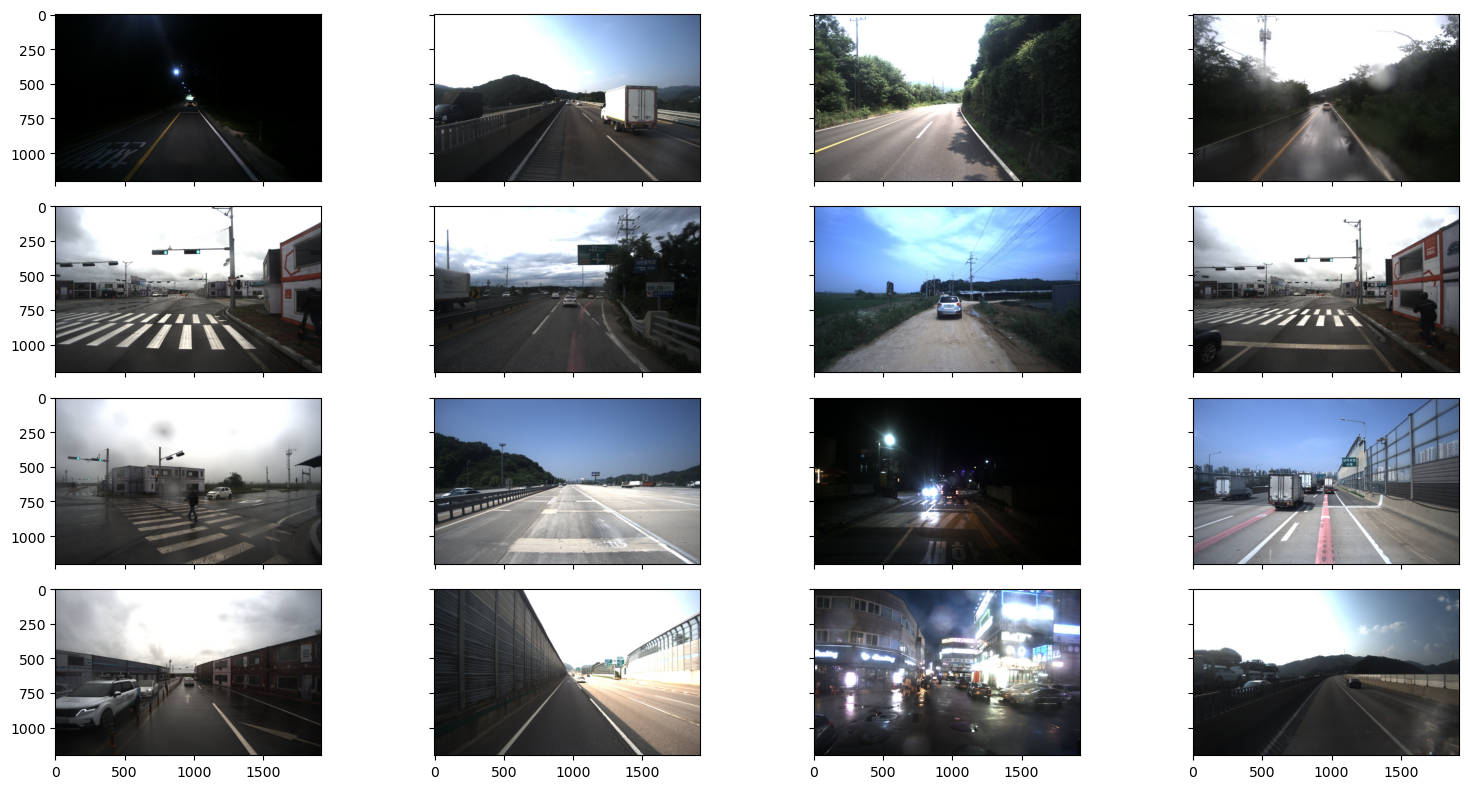

In [7]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]

# create the plot 
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    # read the image
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)
    
    # calculate the indexes for plots and set the image data
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

.json 파일에서 마스크 로드하기:JSON 파일에는 각 객체의 클래스 이름과 폴리곤 데이터가 포함되어 있으며, 이를 바탕으로 마스크를 생성합니다.

마스크와 원본 이미지 겹치기:
로드한 마스크를 원본 이미지와 겹쳐서 시각화합니다

In [8]:
def load_image(image_path):
    return Image.open(image_path)

def generate_random_color():
    return tuple(np.random.choice(range(256), size=3))

def load_mask(json_path, image_size):
    with open(json_path) as f:
        data = json.load(f)
    
    mask = Image.new('RGB', (image_size[0], image_size[1]), (0, 0, 0))
    draw = ImageDraw.Draw(mask)
    
    for annotation in data['Annotation']:
        color = generate_random_color()
        for polygon_data in annotation['data']:
            polygon = [(polygon_data[i], polygon_data[i+1]) for i in range(0, len(polygon_data), 2)]
            draw.polygon(polygon, outline=color, fill=color)
    
    return np.array(mask)

def plot_segmentation(image, mask):
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Segmentation Mask')
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')
    
    plt.show()

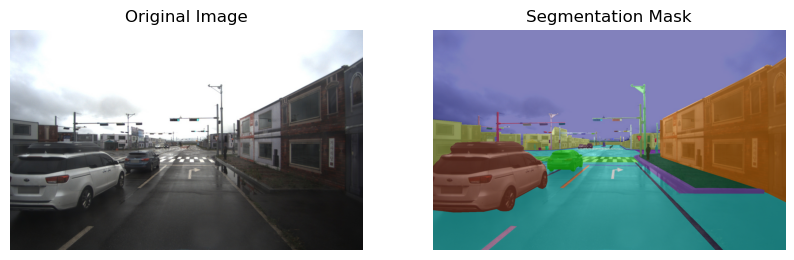

In [9]:
# Example usage
image_path = "/mnt/datasets/2DSS/2DSS/training/images/E_DCG_230829_141_FC_008.jpg"
json_path = "/mnt/datasets/2DSS/2DSS/training/labels/E_DCG_230829_141_FC_008.json"

image = load_image(image_path)
mask = load_mask(json_path, image.size)

plot_segmentation(image, mask)

# EDA (train & val 데이터셋만 고려)

## Class별 총 Instance 개수

In [30]:
from collections import defaultdict

def count_instance_per_class(json_paths):

    # 클래스별 인스턴스 개수를 저장할 딕셔너리 초기화
    class_instance_counts = defaultdict(int)

    # 디렉토리 내 모든 JSON 파일 순회
    for json_path in json_paths:
        if json_path.endswith('.json'):
            # JSON 파일 로드
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            # Annotation 부분 순회하며 클래스 이름별 인스턴스 카운트
            for annotation in data['Annotation']:
                class_name = annotation['class_name']
                class_instance_counts[class_name] += 1

    class_instance_df = pd.DataFrame(list(class_instance_counts.items()), columns=['class_name', 'instance_count']).sort_values(by='instance_count', ascending=False)

    return class_instance_df

In [32]:
train_class_instance_df = count_instance_per_class(training_masks_paths)
val_class_instance_df = count_instance_per_class(validation_masks_paths)

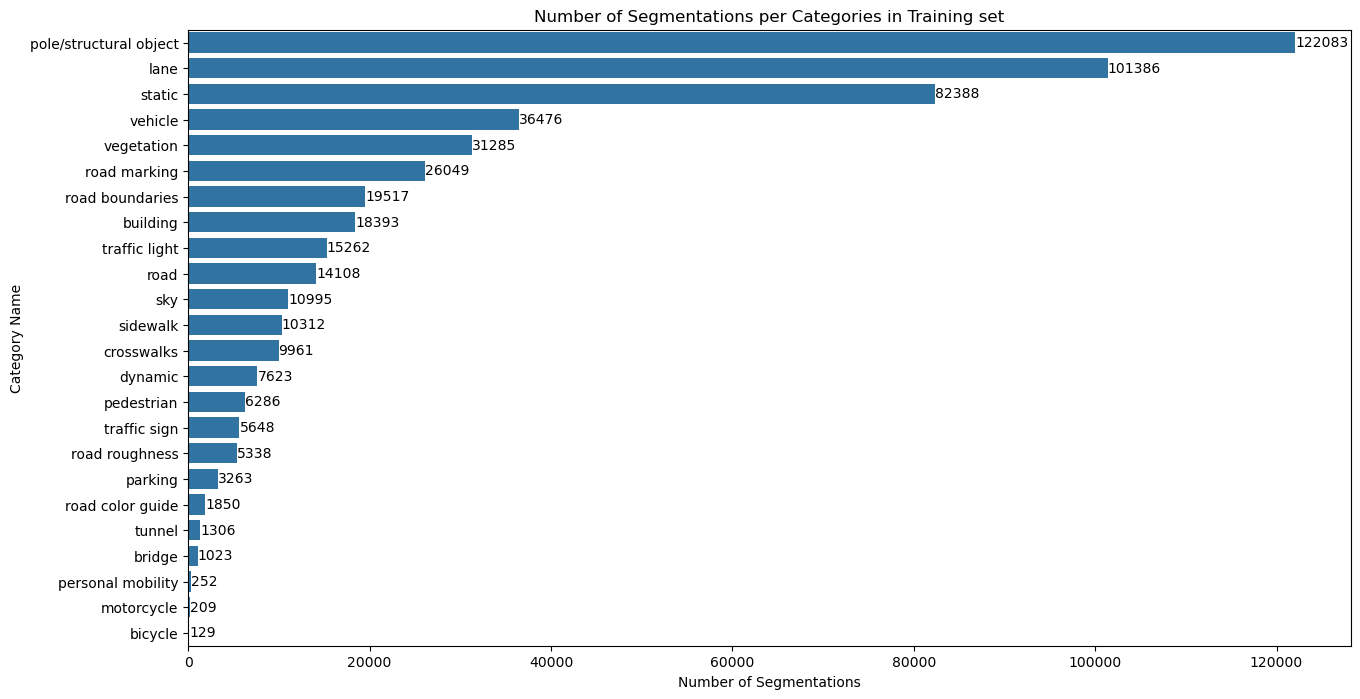

In [33]:
# Train data의 class 별 개수
plt.figure(figsize=(15, 8))
ax = sns.barplot(x='instance_count', y='class_name', data=train_class_instance_df)

plt.title('Number of Segmentations per Categories in Training set')
plt.xlabel('Number of Segmentations')
plt.ylabel('Category Name')

for i in ax.containers:
    ax.bar_label(i, fmt='%.0f')

plt.show()

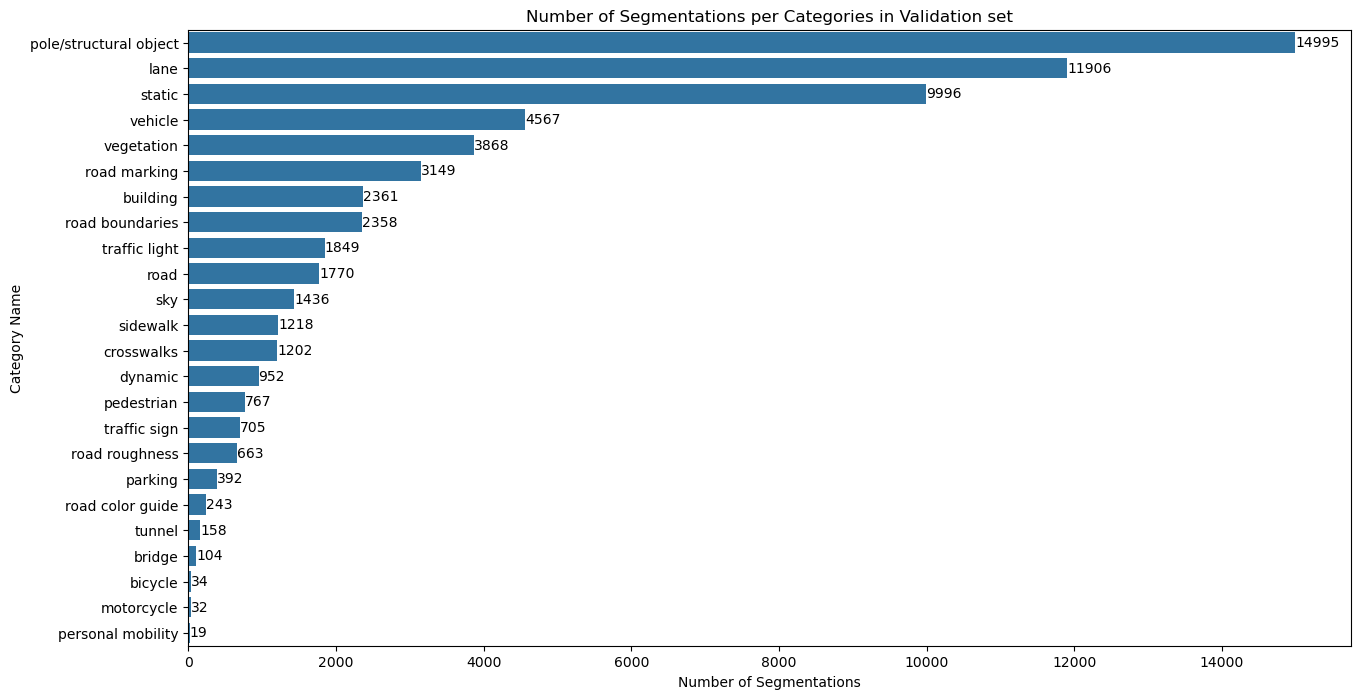

In [34]:
# Val data의 class 별 개수
plt.figure(figsize=(15, 8))
ax = sns.barplot(x='instance_count', y='class_name', data=val_class_instance_df)

plt.title('Number of Segmentations per Categories in Validation set')
plt.xlabel('Number of Segmentations')
plt.ylabel('Category Name')

for i in ax.containers:
    ax.bar_label(i, fmt='%.0f')

plt.show()

## Image 별 instance 개수

In [38]:
def count_instance_per_img(json_paths):
    # 클래스별 인스턴스 개수를 저장할 딕셔너리 초기화
    img_instance_counts = defaultdict(int)

    # 디렉토리 내 모든 JSON 파일 순회
    for json_path in json_paths:
        if json_path.endswith('.json'):
            # JSON 파일 로드
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            # 이미지 이름과 인스턴스 개수 카운트
            image_name = data['image_name']
            instance_count = len(data['Annotation'])

            # 딕셔너리에 이미지 이름과 인스턴스 개수 추가
            img_instance_counts[image_name] = instance_count

    image_instance_df = pd.DataFrame(list(img_instance_counts.items()), columns=['image_name', 'instance_count'])

    return image_instance_df

In [40]:
train_img_instance_df = count_instance_per_img(training_masks_paths)
val_img_instance_df = count_instance_per_img(validation_masks_paths)

In [ ]:
image_instance_df.instance_count.value_counts()

In [ ]:
image_instance_df.instance_count.mean()

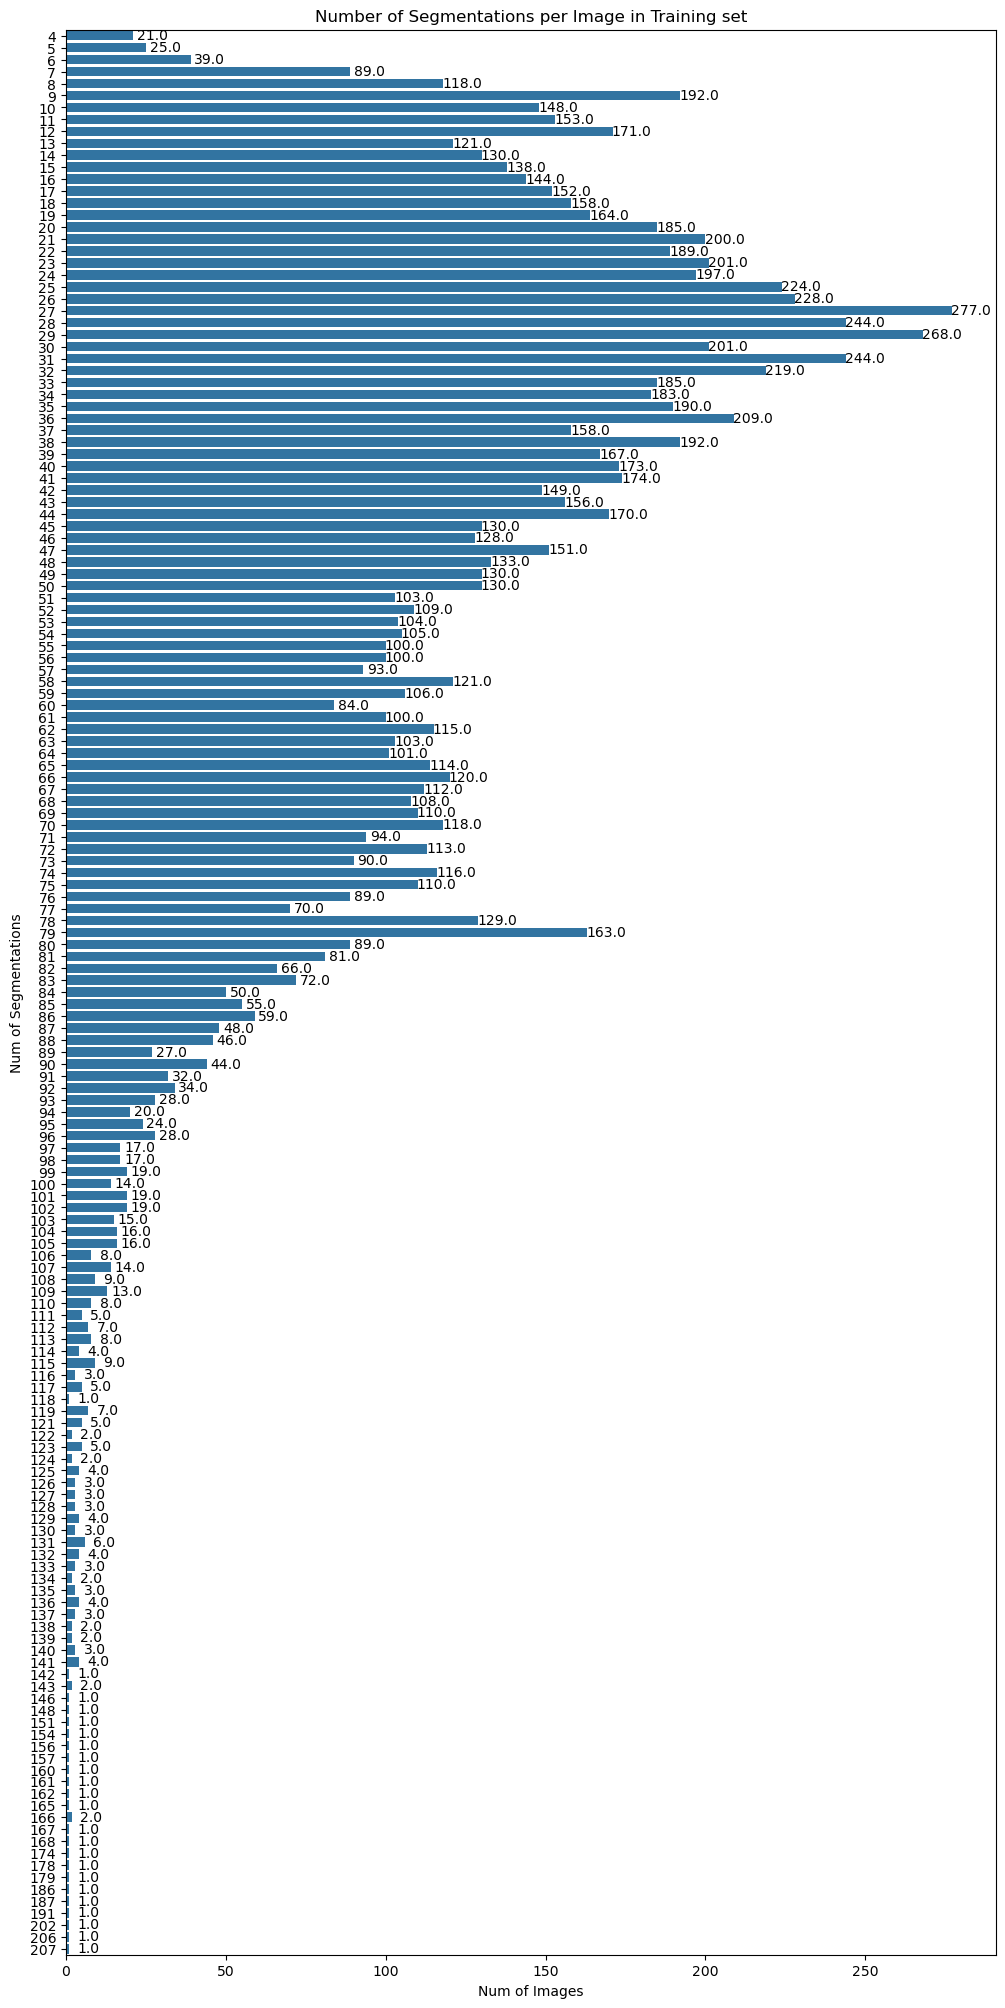

In [41]:
# Seaborn을 사용하여 가로 막대 그래프 그리기 (countplot 사용)
plt.figure(figsize=(12, 25))
ax = sns.countplot(y=train_img_instance_df['instance_count'])

plt.title('Number of Segmentations per Image in Training set')
plt.xlabel('Num of Images')
plt.ylabel('Num of Segmentations')

# 막대 그래프에 값 추가
for p in ax.patches:
    count = p.get_width()
    ax.text(count + 6.0, p.get_y() + p.get_height() / 2, f'{count}', ha='center', va='center')

plt.show()

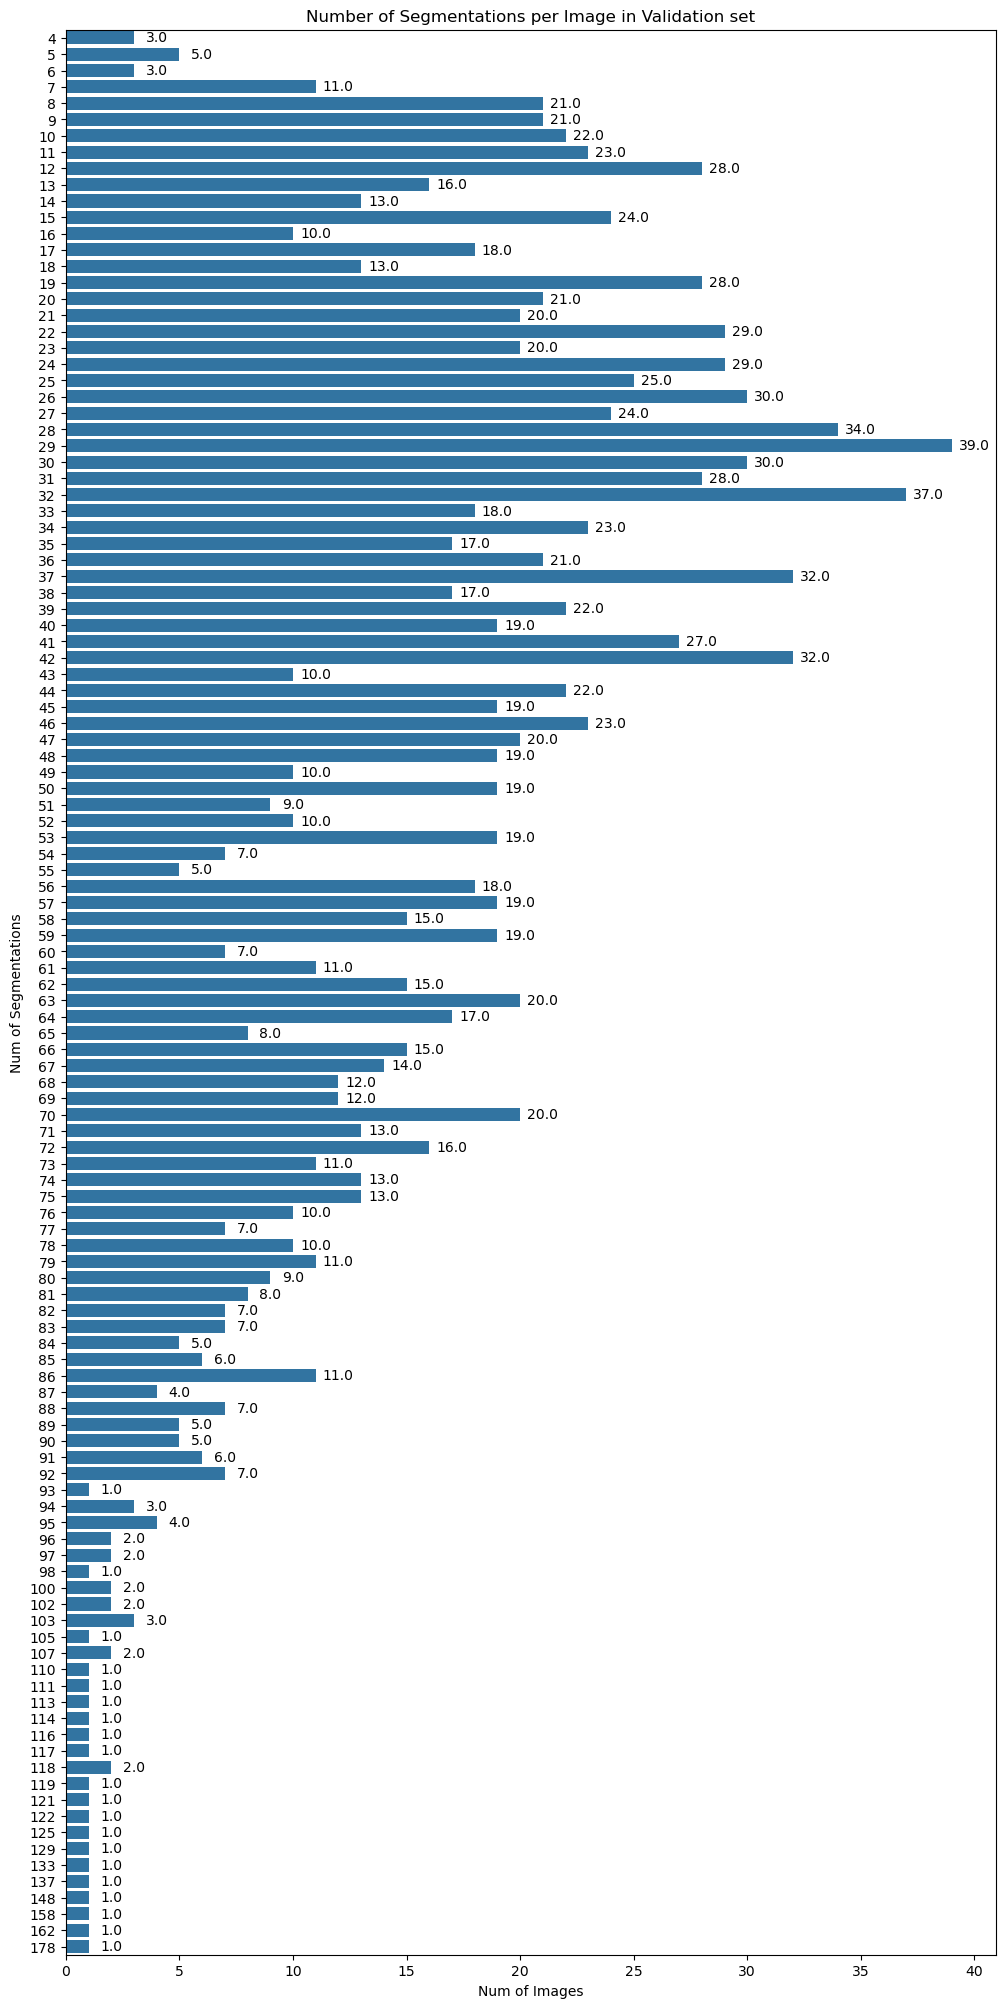

In [44]:
# Seaborn을 사용하여 가로 막대 그래프 그리기 (countplot 사용)
plt.figure(figsize=(12, 25))
ax = sns.countplot(y=val_img_instance_df['instance_count'])

plt.title('Number of Segmentations per Image in Validation set')
plt.xlabel('Num of Images')
plt.ylabel('Num of Segmentations')

# 막대 그래프에 값 추가
for p in ax.patches:
    count = p.get_width()
    ax.text(count + 1.0, p.get_y() + p.get_height() / 2, f'{count}', ha='center', va='center')

plt.show()

## 카테고리별 segmentation 면적 분포

In [52]:
# Shoelace 공식으로 폴리곤의 면적 계산
def polygon_area(coords):
    n = len(coords)
    area = 0.0
    for i in range(n):
        x1, y1 = coords[i]
        x2, y2 = coords[(i + 1) % n]
        area += x1 * y2 - x2 * y1
    return abs(area) / 2.0

def area_per_class(json_paths):
    # 카테고리별 면적을 저장할 딕셔너리 초기화
    cat_area_dict = defaultdict(int)

    # 디렉토리 내 모든 JSON 파일 순회
    for json_path in json_paths:
        if json_path.endswith('.json'):
            # JSON 파일 로드
            with open(json_path, 'r') as f:
                data = json.load(f)
            
            # Annotation 부분 순회하며 클래스 이름별 인스턴스 카운트
            for annotation in data['Annotation']: 
                class_name = annotation['class_name']
                point = annotation['data']           
                # 좌표를 (x, y) 형태로 변환
                polygon = [(point[0][i], point[0][i + 1]) for i in range(0, len(point[0]), 2)]
                
                # 면적 계산
                area = polygon_area(polygon)
                cat_area_dict[class_name] += area

    class_area_df = pd.DataFrame(list(cat_area_dict.items()), columns=['class_name', 'area']).sort_values(by='area', ascending=False)

    return class_area_df

In [56]:
train_class_area_df = area_per_class(training_masks_paths)
val_class_area_df = area_per_class(validation_masks_paths)

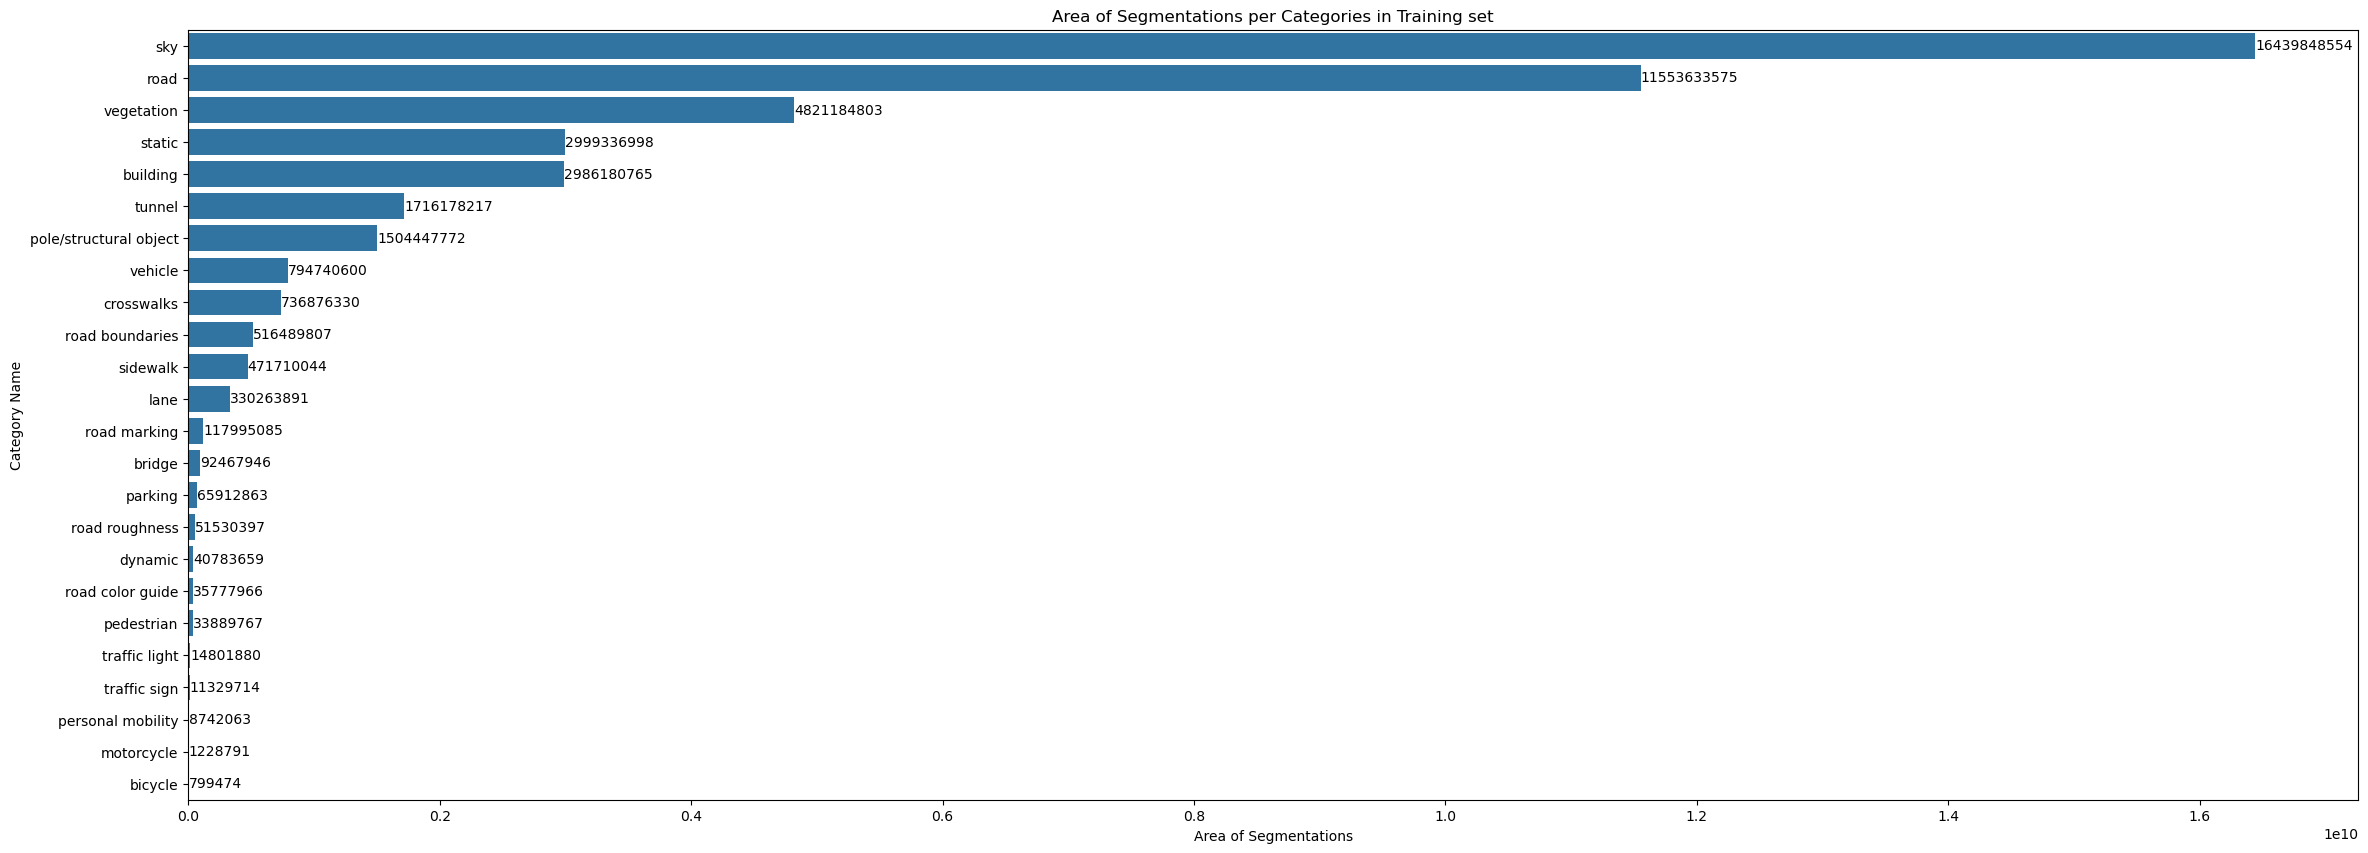

In [61]:
# Seaborn을 사용하여 가로 막대 그래프 그리기 (barplot 사용)
plt.figure(figsize=(28, 10))
ax = sns.barplot(x='area', y='class_name', data=train_class_area_df)

plt.title('Area of Segmentations per Categories in Training set')
plt.xlabel('Area of Segmentations')
plt.ylabel('Category Name')

for i in ax.containers:
    ax.bar_label(i, fmt='%.0f')

plt.show()

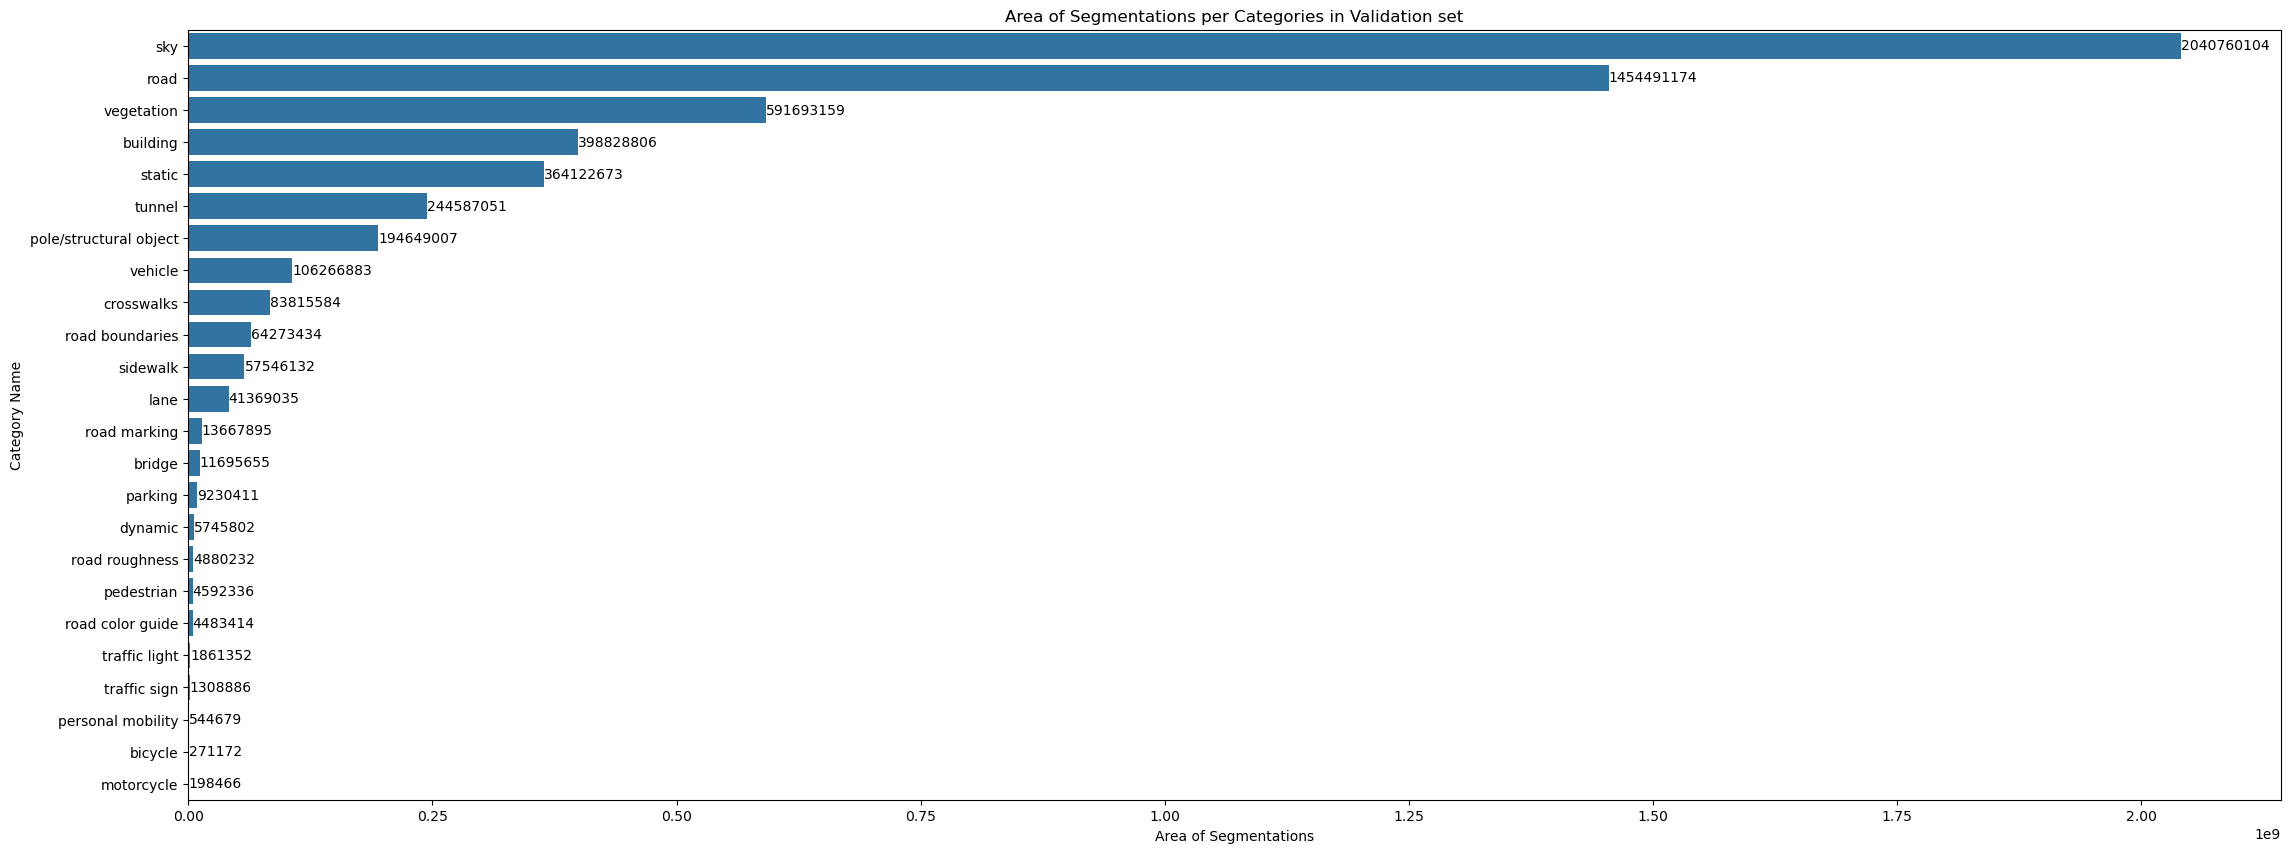

In [63]:
# Seaborn을 사용하여 가로 막대 그래프 그리기 (barplot 사용)
plt.figure(figsize=(27, 10))
ax = sns.barplot(x='area', y='class_name', data=val_class_area_df)

plt.title('Area of Segmentations per Categories in Validation set')
plt.xlabel('Area of Segmentations')
plt.ylabel('Category Name')

for i in ax.containers:
    ax.bar_label(i, fmt='%.0f')

plt.show()